This script is the code for Figure 3 in https://arxiv.org/abs/2006.11988

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import pandas as pd

In [3]:
import torchxrayvision as xrv

In [4]:
model = xrv.models.DenseNet(weights="all").cuda()

In [5]:
import torchvision, torchvision.transforms
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

In [6]:
d_kaggle = xrv.datasets.RSNA_Pneumonia_Dataset(
                imgpath="/lustre03/project/6008064/jpcohen/kaggle-pneumonia/stage_2_train_images_jpg",
                transform=transform)

In [7]:
d_kagglef = xrv.datasets.FilterDataset(d_kaggle, labels=["Pneumonia"])

filtering for  Pneumonia


In [8]:
d_kagglef

{'Lung Opacity': {1.0: 1767}, 'Pneumonia': {1.0: 1767}}


FilterDataset num_samples=1767

In [ ]:
d_covid19 = xrv.datasets.COVID19_Dataset(transform=transform,
                                         imgpath="../../covid-chestxray-dataset/images",
                                         csvpath="../../covid-chestxray-dataset/metadata.csv",
                                         views=['PA', 'AP', "AP Supine"])

In [14]:
d_covid19

{'ARDS': {0.0: 449, 1.0: 16},
 'Bacterial Pneumonia': {0.0: 436, 1.0: 29},
 'COVID-19': {0.0: 106, 1.0: 359},
 'Chlamydophila': {0.0: 464, 1.0: 1},
 'Fungal Pneumonia': {0.0: 452, 1.0: 13},
 'Influenza': {0.0: 464, 1.0: 1},
 'Klebsiella': {0.0: 458, 1.0: 7},
 'Legionella': {0.0: 461, 1.0: 4},
 'Lipoid': {0.0: 462, 1.0: 3},
 'MERS': {0.0: 465},
 'Mycoplasma': {0.0: 461, 1.0: 4},
 'No Finding': {0.0: 452, 1.0: 13},
 'Pneumocystis': {0.0: 452, 1.0: 13},
 'Pneumonia': {0.0: 23, 1.0: 442},
 'SARS': {0.0: 449, 1.0: 16},
 'Streptococcus': {0.0: 452, 1.0: 13},
 'Varicella': {0.0: 461, 1.0: 4},
 'Viral Pneumonia': {0.0: 85, 1.0: 380}}


COVID19_Dataset num_samples=465 views=['PA', 'AP', 'AP Supine']

In [15]:
train_size = int(0.5 * len(d_covid19))
test_size = len(d_covid19) - train_size
torch.manual_seed(0)
d_covid19_train, d_covid19_test = torch.utils.data.random_split(d_covid19, [train_size, test_size])

In [16]:
xrv.datasets.relabel_dataset(d_covid19.pathologies, d_kagglef)

In [17]:
#dmerge = xrv.datasets.Merge_Dataset([d_covid19])
dmerge = xrv.datasets.Merge_Dataset([d_covid19, d_kagglef])

In [18]:
dmerge

{'ARDS': {0.0: 449, 1.0: 16},
 'Bacterial Pneumonia': {0.0: 436, 1.0: 29},
 'COVID-19': {0.0: 106, 1.0: 359},
 'Chlamydophila': {0.0: 464, 1.0: 1},
 'Fungal Pneumonia': {0.0: 452, 1.0: 13},
 'Influenza': {0.0: 464, 1.0: 1},
 'Klebsiella': {0.0: 458, 1.0: 7},
 'Legionella': {0.0: 461, 1.0: 4},
 'Lipoid': {0.0: 462, 1.0: 3},
 'MERS': {0.0: 465},
 'Mycoplasma': {0.0: 461, 1.0: 4},
 'No Finding': {0.0: 452, 1.0: 13},
 'Pneumocystis': {0.0: 452, 1.0: 13},
 'Pneumonia': {0.0: 23, 1.0: 2209},
 'SARS': {0.0: 449, 1.0: 16},
 'Streptococcus': {0.0: 452, 1.0: 13},
 'Varicella': {0.0: 461, 1.0: 4},
 'Viral Pneumonia': {0.0: 85, 1.0: 380}}


Merge_Dataset num_samples=2232

In [19]:
dl = torch.utils.data.DataLoader(dmerge, batch_size=32, num_workers=16, pin_memory=True)

In [127]:
d_feats = []
d_preds = []
with torch.no_grad():
    for i, batch in enumerate(dl):
        imgs = batch["img"].cuda()
        out = model.features(imgs)
        out = F.relu(out, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        pred = model.classifier(out.view(out.size(0), -1))
        d_feats.append(out.detach().cpu().numpy())
        d_preds.append(pred.detach().cpu().numpy())
        if i %10 == 0:
            print(i)
d_feats = np.concatenate(d_feats).reshape(-1,1024)
d_preds = np.concatenate(d_preds)

0
10
20
30
40
50
60


In [23]:
import pickle as pkl

In [24]:
#pkl.dump([d_feats, d_preds], open("feats-kaggle-covid.pkl", "bw"))
d_feats, d_preds = pkl.load(open("feats-kaggle-covid.pkl", "br"))

In [25]:
dmerge.csv = dmerge.csv.reset_index()

In [26]:
#dmerge.csv.join(pd.DataFrame(d_preds, columns=xrv.datasets.default_pathologies))

In [27]:
dmerge.csv = dmerge.csv.join(pd.DataFrame(d_preds, columns=xrv.datasets.default_pathologies))

In [28]:
dmerge.csv["offset"] = dmerge.csv["offset"].astype(float)

In [29]:
d_preds.shape

(2232, 18)

In [30]:
d_feats.shape

(2232, 1024)

In [31]:
# import sklearn, sklearn.manifold
# X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(d_preds)
# X_embedded.shape

In [32]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import umap
    reducer = umap.UMAP(n_neighbors=30,
                      min_dist=0.5,
                      n_components=3,
                      random_state=0)
    
    X_embedded = reducer.fit_transform(d_preds)
    X_embedded.shape

/home/cohenjos/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [33]:
X_embedded.shape[0]

2232

In [34]:
dmerge.csv.columns

Index(['index', 'patientid', 'offset', 'sex', 'age', 'finding', 'survival',
       'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 28', 'patientId',
       'x', 'y', 'width', 'height', 'Target', 'Unnamed: 0', 'BodyPartExamined',
       'ConversionType', 'Filename', 'InstanceNumber', 'Modality',
       'PatientAge', 'PatientOrientation', 'PatientSex', 'PixelSpacing',
       'SamplesPerPixel', 'SeriesNumber', 'ViewPosition', 'Atelectasis',
       'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
       'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture',
       'Lung Opacity', 'Enlarged Cardi

In [36]:
#targets = dmerge.csv["Lung Opacity"]

In [270]:
dmerge.csv["statebad"] = (dmerge.csv.in_icu == "Y") | (dmerge.csv.intubation_present == "Y")
dmerge.csv["stategood"] = (dmerge.csv.in_icu == "N") | (dmerge.csv.intubation_present == "N")


In [271]:
for name, group in dmerge.csv.groupby("patientid"):
    rows = group.sort_values("offset")
    # mask for last state
    mask = (dmerge.csv.patientid.isin(rows[-1:].patientid) & dmerge.csv.offset.isin(rows[-1:].offset))
    
    if (dmerge.csv[mask].survival == "Y").all():
        dmerge.csv["stategood"][mask] = True

    if (dmerge.csv[mask].survival == "N").all():
        dmerge.csv["statebad"][mask] = True
    

In [168]:
targets = dmerge.csv.Pneumothorax

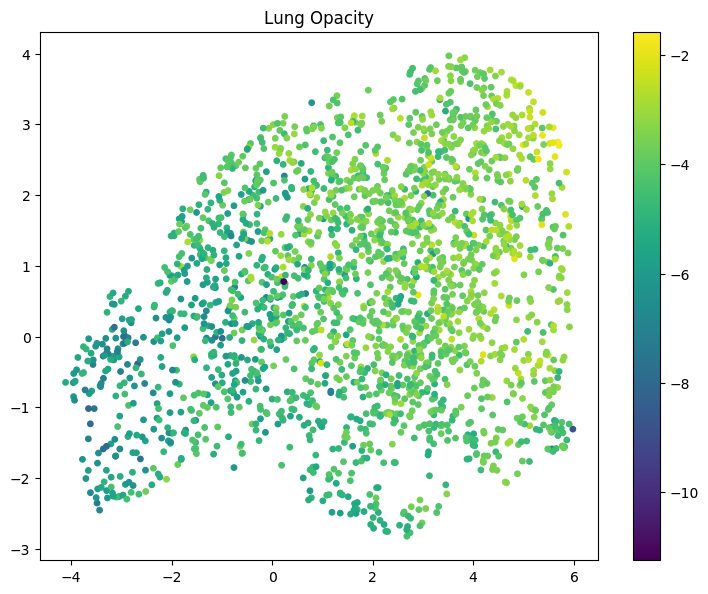

In [37]:
plt.figure(0, figsize=(9, 7), dpi=100)

plt.scatter(X_embedded[:,0][targets.isna()], 
            X_embedded[:,1][targets.isna()], 
            s=8,
            label="nan",
            c="lightgray"
            );

plt.scatter(X_embedded[:,0], 
            X_embedded[:,1], 
            #s=(targets==2)*20+1,
            c=targets,
            s=15
            );
plt.colorbar();
plt.title("Lung Opacity");



In [104]:
targets = dmerge.csv.survival

In [105]:
#targets = dmerge.csv.view == "AP Supine"

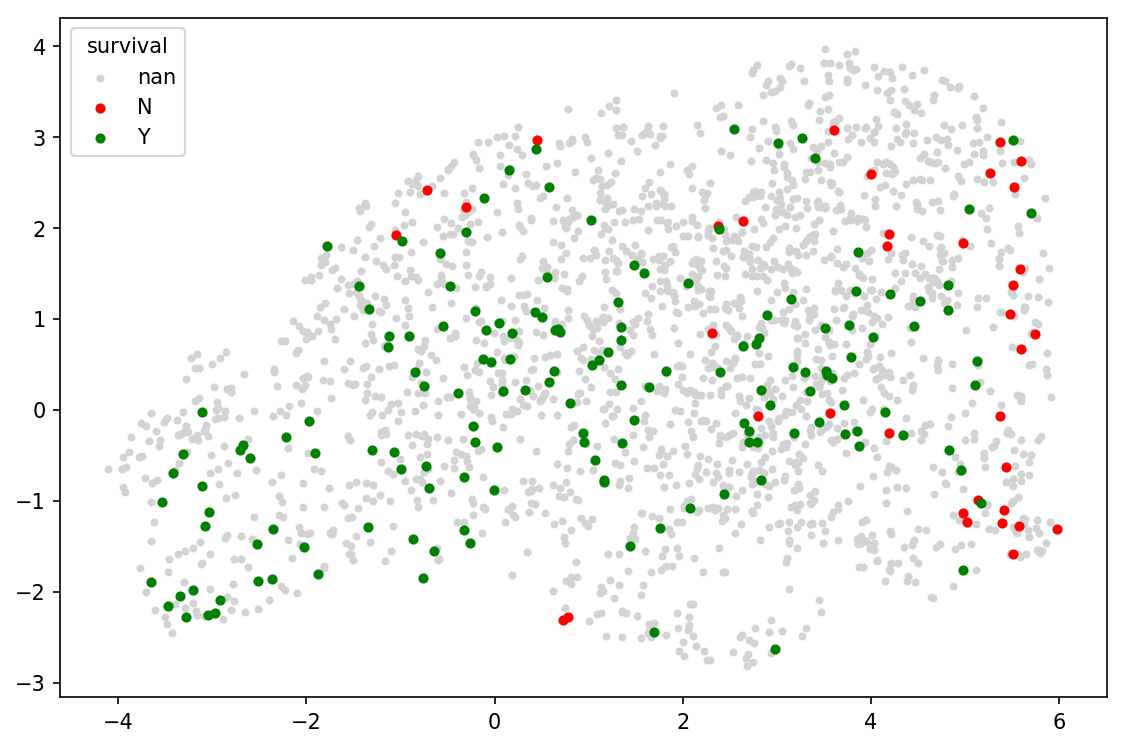

In [106]:
plt.figure(0, figsize=(9, 6), dpi=150)

plt.scatter(X_embedded[:,0][targets.isna()], 
            X_embedded[:,1][targets.isna()], 
            s=8,
            label="nan",
            c="lightgray"
            );
colors = ["Red","Green",  "Blue"]
for i, label in enumerate(sorted(targets[~targets.isna()].unique())):
    plt.scatter(X_embedded[:,0][targets == label], 
                X_embedded[:,1][targets == label], 
                s=15,
                label=label,
                c=colors[i]
                );
    
plt.legend(title=targets.name);

In [341]:
targets = pd.Series([np.nan]*len(dmerge.csv), name="State")
targets[dmerge.csv.statebad] = "Bad"
targets[dmerge.csv.stategood] = "Good"

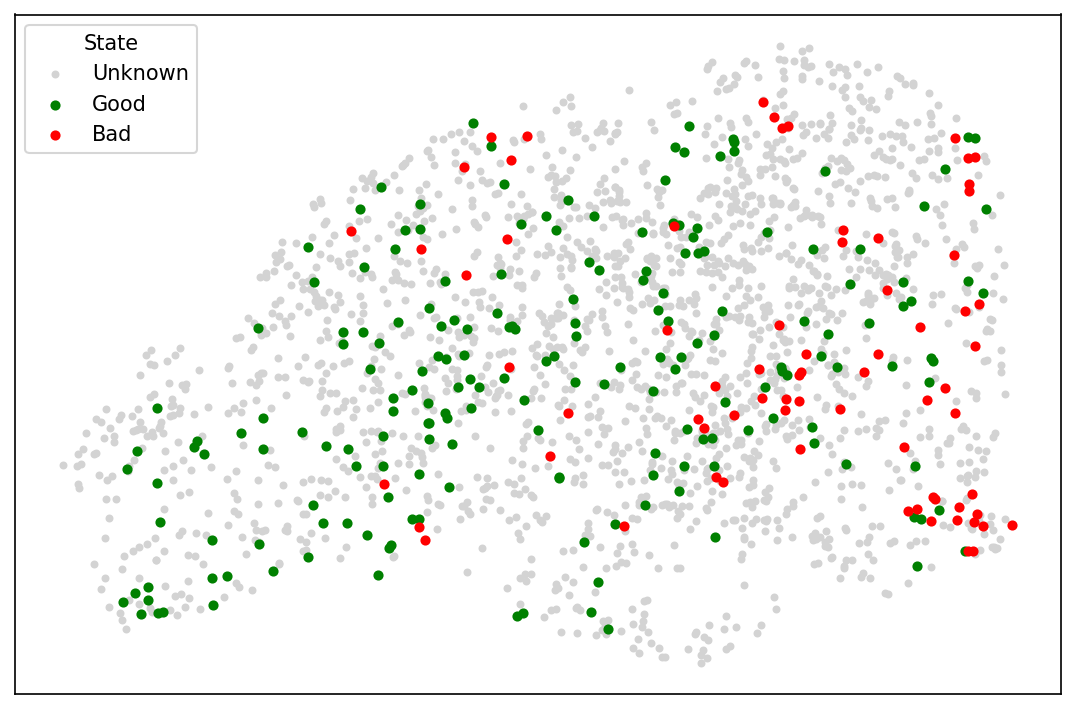

In [345]:
plt.figure(0, figsize=(9, 6), dpi=150)

plt.scatter(X_embedded[:,0][targets.isna()], 
            X_embedded[:,1][targets.isna()], 
            s=8,
            label="Unknown",
            c="lightgray"
            );
colors = {"Good":"Green", "Bad":"Red"}
for i, label in enumerate(targets[~targets.isna()].unique()):
    plt.scatter(X_embedded[:,0][targets == label], 
                X_embedded[:,1][targets == label], 
                s=15,
                label=label,
                c=colors[label]
                );
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.legend(title=targets.name);

In [111]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, extent=None,**kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    if extent:
        # create grid of sample locations (default: 100x100)
        xx, yy = np.mgrid[extent[0]:extent[1]:xbins, 
                          extent[2]:extent[3]:ybins]
    else:
        # create grid of sample locations (default: 100x100)
        xx, yy = np.mgrid[x.min():x.max():xbins, 
                          y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [112]:
dmerge.csv.columns

Index(['index', 'patientid', 'offset', 'sex', 'age', 'finding', 'survival',
       'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 28', 'patientId',
       'x', 'y', 'width', 'height', 'Target', 'Unnamed: 0', 'BodyPartExamined',
       'ConversionType', 'Filename', 'InstanceNumber', 'Modality',
       'PatientAge', 'PatientOrientation', 'PatientSex', 'PixelSpacing',
       'SamplesPerPixel', 'SeriesNumber', 'ViewPosition', 'Atelectasis',
       'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
       'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture',
       'Lung Opacity', 'Enlarged Cardi

In [113]:
targets = dmerge.csv.survival

In [114]:
# icu_cases = dmerge.csv[(dmerge.csv.in_icu == "Y") | (dmerge.csv.intubation_present == "Y")]
# xx, yy, zz = kde2D(icu_cases.x_emb, icu_cases.y_emb, 1.0, extent=[-5,5,-5,6])
# h = plt.pcolormesh(xx, yy, zz, cmap="PiYG_r", alpha=0.1);
# cbar = plt.colorbar(h);
# cbar.set_label('Patients in ICU or intubated', rotation=270, labelpad=9)

red
red
red
red
green
red
red
red
red
green
green
green


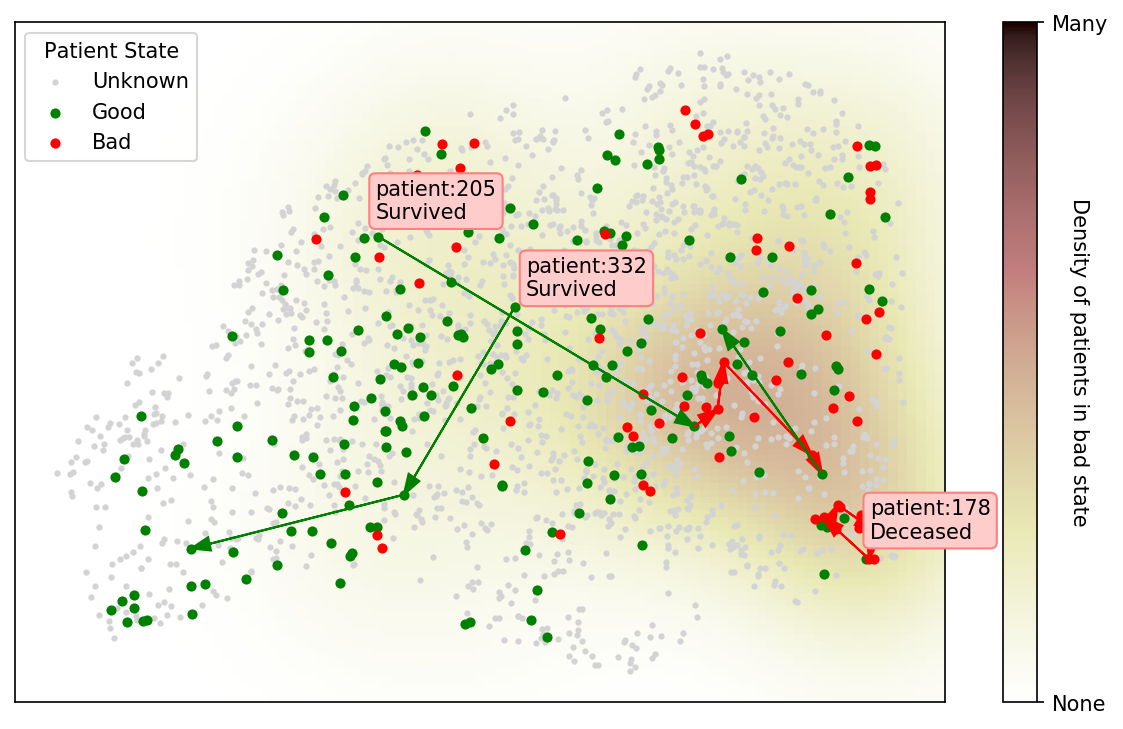

In [340]:
#253, 205, 245, 250
# dead 178
# recovers 332, 2, 19, 173, 263
patientids = ["178", "332", "205"]
plt.figure(0, figsize=(10, 6), dpi=150)

targets = pd.Series([np.nan]*len(dmerge.csv), name="State")
targets[dmerge.csv.statebad] = "Bad"
targets[dmerge.csv.stategood] = "Good"

dmerge.csv["x_emb"] = X_embedded[:,0]
dmerge.csv["y_emb"] = X_embedded[:,1]

plt.scatter(X_embedded[:,0][targets.isna()], 
            X_embedded[:,1][targets.isna()], 
            s=0,
            c="lightgray"
            );

statebad = dmerge.csv[dmerge.csv.statebad]
extent = plt.xlim() + plt.ylim()
#extent=[-5,5,-5,6]
xx, yy, zz = kde2D(statebad.x_emb, statebad.y_emb, 1.0,extent=extent)
h = plt.pcolormesh(xx, yy, zz, cmap="pink_r",vmax=0.09);
cbar = plt.colorbar(h, ticks=[0,0.09]);
cbar.ax.set_yticklabels(['None', 'Many'])
cbar.set_label('Density of patients in bad state', rotation=270, labelpad=-9)

plt.scatter(X_embedded[:,0][targets.isna()], 
            X_embedded[:,1][targets.isna()], 
            s=4,
            label="Unknown",
            c="lightgray"
            );
colors = {"Good":"Green", "Bad":"Red"}
for i, label in enumerate(targets[~targets.isna()].unique()):
    plt.scatter(X_embedded[:,0][targets == label], 
                X_embedded[:,1][targets == label], 
                s=15,
                label=label,
                c=colors[label]
                );

for name, group in dmerge.csv.groupby("patientid"):
    rows = group.sort_values("offset")
    if not rows.iloc[0].patientid in patientids:
        continue;
    color = "gray"
    x_0,y_0 = rows.iloc[0]["x_emb"], rows.iloc[0]["y_emb"]
    outcome = ""
    if rows.iloc[0].survival == "Y":
        outcome = "Survived"
    elif rows.iloc[0].survival == "N":
        outcome = "Deceased"
    plt.text(x_0*1.1,y_0*1.1, "patient:" + rows.iloc[0].patientid + "\n" + outcome,          
             bbox=dict(boxstyle="round",
             ec=(1., 0.5, 0.5),
             fc=(1., 0.8, 0.8),
        ))
    for i in range(1,len(rows)):
        if rows.iloc[i].statebad:
            color="red"
        elif rows.iloc[i].stategood:    
            color="green"
        print(color)
        x_1,y_1 = rows.iloc[i]["x_emb"], rows.iloc[i]["y_emb"]
        plt.arrow(x_0,y_0,x_1-x_0,y_1-y_0, length_includes_head=True, head_width=0.15, overhang=0,color=color)
        x_0,y_0 = x_1,y_1
        
plt.legend(title="Patient State");
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
#plt.title("Trajectory for patientid " + patientid);
